# Train Vec4Gloss - defgen

In [1]:
## reference: https://huggingface.co/course/chapter7/4

In [2]:
%env WANDB_PROJECT=vec4gloss

env: WANDB_PROJECT=vec4gloss


In [3]:
%load_ext autoreload
%autoreload 2
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [4]:
from vec4gloss import check_hashes
from vec4gloss import Vec4GlossModel
from pathlib import Path
from datasets import Dataset
from datetime import datetime
import numpy as np
from tqdm.auto import tqdm

## Data dependencies

```
(data) -> ../data/defgen_dataset_cwn/train/dataset.arrow 65a56d
20.10 -> ../data/models/vec4gloss-denoise-(?) 
```

In [5]:
_ = check_hashes([
    "../data/defgen_dataset_cwn/train/dataset.arrow",
    # "../data/models/vec4gloss-denoise-(?)"
])

../data/defgen_dataset_cwn/train/dataset.arrow 65a56d


## Prepare dataset

In [6]:
import numpy as np
from transformers import MT5ForConditionalGeneration, MT5TokenizerFast
from transformers import DataCollatorForSeq2Seq
import datasets
from datasets import load_metric

In [7]:
ds_defgen = datasets.load_from_disk("../data/defgen_dataset_cwn")

In [8]:
print({k: len(v) for k, v in ds_defgen.items()})

{'train': 76969, 'test': 8553}


In [9]:
tokenizer = MT5TokenizerFast.from_pretrained("google/mt5-base")

/home/seantyh/miniconda3/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### Eye-balling

In [10]:
ds_defgen["train"][10:12]

{'cwnid': ['07060501', '09309106'],
 'src': ['縣委書記也拿不出辦法來，只好建議各社將曬乾的紅薯藤子磨成<粉>，煮成糊糊，藉以維持生命。',
  '行萬里路也不是為了收集更多的繪畫素材，而是為了<開闊>胸襟。'],
 'tgt': ['Na。極細的小顆粒。', 'VHC。使心胸寬大。']}

## Preprocess

In [11]:
def get_marked_pos(text):
    assert text.count("<") == text.count(">") == 1
    s, e = text.index("<")+1, text.index(">")
    assert s != e
    return s, e

In [12]:
## eye-balling
print(ds_defgen["train"][10]["src"])
ds_defgen["train"][10]["src"][slice(*get_marked_pos(ds_defgen["train"][10]["src"]))]

縣委書記也拿不出辦法來，只好建議各社將曬乾的紅薯藤子磨成<粉>，煮成糊糊，藉以維持生命。


'粉'

In [13]:
max_length = 256
def add_marked_pos(ex):
    pos = get_marked_pos(ex["src"])
    return {"decoder_start_markers": pos[0], "decoder_end_markers": pos[1]}

def preprocess_fn(batch):    
    src_batch = tokenizer(batch["src"], 
                          max_length=max_length, truncation=True)
    start_markers = [src_batch.char_to_token(bi,s) 
                     for bi, s in enumerate(batch["decoder_start_markers"])]
    end_markers = [src_batch.char_to_token(bi,e) 
                   for bi, e in enumerate(batch["decoder_end_markers"])]
    
    with tokenizer.as_target_tokenizer():
        tgt_batch = tokenizer(batch["tgt"],
                              max_length=max_length, truncation=True)        
        
    return {
        **src_batch, 
        "decoder_start_markers": start_markers,
        "decoder_end_markers": end_markers,
        "labels": tgt_batch["input_ids"]
    }

In [14]:
drop_columns = ["cwnid", "src", "tgt"]
ds_defgen = (ds_defgen.map(add_marked_pos)
             .map(preprocess_fn, batched=True, remove_columns=drop_columns))

Loading cached processed dataset at ../data/defgen_dataset_cwn/train/cache-edc9a2f8200950ba.arrow
Loading cached processed dataset at ../data/defgen_dataset_cwn/test/cache-cdf34f4111063fd7.arrow
Loading cached processed dataset at ../data/defgen_dataset_cwn/train/cache-c0432bb9c2303e59.arrow
Loading cached processed dataset at ../data/defgen_dataset_cwn/test/cache-20c16d911073640a.arrow


### Eye-balling

In [15]:
print(" ".join(tokenizer.convert_ids_to_tokens(ds_defgen["train"][14]["input_ids"])))
print(" ".join(tokenizer.convert_ids_to_tokens(ds_defgen["train"][14]["labels"])))

▁ 募 款 委員 曾 率 工作 同 仁 , 分 赴 國 內 、 外 各地 校 友 會 舉 辦 < 勸 募 > 說 明 會 , 帶 動 募 款 的 風 氣 。 </s>
▁nom , VD 。 以 勸 說 的方式 希望 能 廣 泛 收集 到 他人 財 物 。 </s>


In [16]:
ent = ds_defgen["train"][14]
xids = ent["input_ids"]
tokenizer.convert_ids_to_tokens(xids[ent["decoder_start_markers"]:ent["decoder_end_markers"]])

['勸', '募']

## Define BLEU metrics

In [17]:
metric = load_metric("sacrebleu")

In [18]:
metric.compute(predictions=["中文數字"], references=[["中文數學"]], tokenize="char")

{'score': 59.460355750136046,
 'counts': [3, 2, 1, 0],
 'totals': [4, 3, 2, 1],
 'precisions': [75.0, 66.66666666666667, 50.0, 50.0],
 'bp': 1.0,
 'sys_len': 4,
 'ref_len': 4}

In [19]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
  
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, 
                            tokenize="char")
    return {"bleu": result["score"]}

## Trainer

In [20]:
# import wandb
# wandb.login()

In [21]:
model = Vec4GlossModel.from_pretrained("google/mt5-base").to("cuda")
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding="longest")

In [22]:
out_dir = Path("/mnt/md0/seantyh/vec4gloss")
if not out_dir.exists():
    out_dir = "vec4gloss"
print(out_dir)

/mnt/md0/seantyh/vec4gloss


In [23]:
from transformers import Seq2SeqTrainingArguments
timestamp = datetime.now().strftime("%y%m%d-%H%M")

args = Seq2SeqTrainingArguments(
    out_dir,
    evaluation_strategy="steps",
    save_strategy="no",    
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=100,  # 10 for debug, else 500
    eval_steps=3000,
    save_total_limit=3,
    num_train_epochs=1,
    # report_to="wandb",
    run_name=f"vec4gloss-{timestamp}",
    predict_with_generate=False,    # can't do it here because of two additional parameters
)

In [24]:
train_ds = ds_defgen["train"]
test_ds = ds_defgen["test"]
# train_ds = train_ds.select(range(100))
# test_ds = test_ds.select(range(200))

In [25]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,       
)

## ignore the following message of tokenizers and fork
## we need tokenizer to check the tokenization, and parallelism doesn't matter here

In [26]:
trainer.train()

/home/seantyh/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 76969
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9622
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: seantyh. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
3000,4.246100,3.309163
6000,3.736000,3.053290
9000,3.651500,2.980402


***** Running Evaluation *****
  Num examples = 8553
  Batch size = 16
***** Running Evaluation *****
  Num examples = 8553
  Batch size = 16
***** Running Evaluation *****
  Num examples = 8553
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=9622, training_loss=4.5205730801187665, metrics={'train_runtime': 1543.0054, 'train_samples_per_second': 49.883, 'train_steps_per_second': 6.236, 'total_flos': 9350709736642560.0, 'train_loss': 4.5205730801187665, 'epoch': 1.0})

## Save model

In [27]:
trainer.save_model(f"../data/models/vec4gloss-defgen-{timestamp}")

Saving model checkpoint to ../data/models/vec4gloss-defgen-220628-1426
Configuration saved in ../data/models/vec4gloss-defgen-220628-1426/config.json
Model weights saved in ../data/models/vec4gloss-defgen-220628-1426/pytorch_model.bin
tokenizer config file saved in ../data/models/vec4gloss-defgen-220628-1426/tokenizer_config.json
Special tokens file saved in ../data/models/vec4gloss-defgen-220628-1426/special_tokens_map.json
Copy vocab file to ../data/models/vec4gloss-defgen-220628-1426/spiece.model


## Sandboxing

In [28]:
import torch
torch.manual_seed(12345)
model = Vec4GlossModel.from_pretrained("google/mt5-small").to("cuda")
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding="longest")

loading configuration file https://huggingface.co/google/mt5-small/resolve/main/config.json from cache at /home/seantyh/.cache/huggingface/transformers/97693496c1a0cae463bd18428187f9e9924d2dfbadaa46e4d468634a0fc95a41.dadce13f8f85f4825168354a04675d4b177749f8f11b167e87676777695d4fe4
Model config MT5Config {
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "d_ff": 1024,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "mt5",
  "num_decoder_layers": 8,
  "num_heads": 6,
  "num_layers": 8,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.20.1",
  "use_cache": true,
  "vocab_size"

In [29]:
from torch.utils.data import DataLoader
import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
train_ds = ds_defgen["train"]
test_ds = ds_defgen["test"]
g_cuda = torch.Generator()
g_cuda.manual_seed(211321)
loader = DataLoader(train_ds, batch_size=2, collate_fn=data_collator, shuffle=True, generator=g_cuda)
from itertools import islice
batches = list(islice(loader, 10))

In [30]:
tokenizer.batch_decode(torch.where(batches[0]["labels"] < 0, 0, batches[0]["labels"]))

['VC。模仿或照原樣重製他人的創意當作自己的。</s>',
 'Nc。美術館的建築物及建築物所在的位置。</s><pad><pad><pad><pad><pad>']

In [31]:
batches[0]["input_ids"][0]

tensor([   259,  13524,   3139,  79761,   1083, 170591, 217109, 159356,  16160,
          4779,    261,   5991,  29693,  38401,  47694,  16160,   4779,  30407,
         24134,   2709, 167138,    669, 233119,  51418,  17481,  10559,   3355,
         62746,    306,      1,      0,      0,      0,      0,      0])

In [32]:
from tqdm.auto import tqdm
loss_vec = []
model.train()
for epoch_i in range(10):
    for batch in batches:
    # for batch in tqdm(loader):
        batch.to("cuda")
        optimizer.zero_grad()
        out = model(**batch)
        loss_vec.append(out.loss.item())
        out.loss.backward()
        optimizer.step()
        if len(loss_vec) > 20:
            break
        if any(np.isnan(x) for x in loss_vec):
            raise Exception("NaN encountered")
            

In [33]:
out = model(**batches[4].to("cuda"), output_hidden_states=True)

In [34]:
out.encoder_last_hidden_state

tensor([[[ 0.5777,  0.0054, -0.2739,  ...,  0.0000, -1.0256, -1.0860]],

        [[ 0.1624, -0.1377, -0.2790,  ..., -0.0433, -0.5198, -0.6283]]],
       device='cuda:0', grad_fn=<CopySlices>)

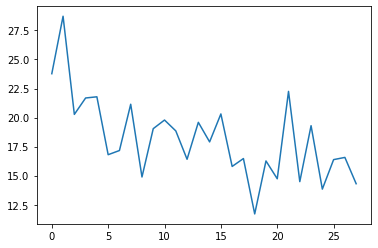

In [35]:
import matplotlib.pyplot as plt
plt.plot(loss_vec)

In [36]:
loss_vec

[23.77428436279297,
 28.720653533935547,
 20.272789001464844,
 21.68494415283203,
 21.787200927734375,
 16.804229736328125,
 17.162992477416992,
 21.14637565612793,
 14.886750221252441,
 19.04545021057129,
 19.787261962890625,
 18.85248565673828,
 16.41023826599121,
 19.589284896850586,
 17.906389236450195,
 20.312131881713867,
 15.793678283691406,
 16.472627639770508,
 11.707213401794434,
 16.2667293548584,
 14.731511116027832,
 22.252975463867188,
 14.485690116882324,
 19.30040740966797,
 13.841635704040527,
 16.380207061767578,
 16.570344924926758,
 14.305279731750488]

In [40]:
with torch.no_grad():    
    out = model(**batches[0])
tokenizer.batch_decode(out.logits.argmax(2))

['<extra_id_0>ြိ引 <extra_id_35>抄尾 <extra_id_53> 抄寄-]  <extra_id_55> <extra_id_5>抄抄引抄',
 '<extra_id_0>rumbre <extra_id_17>内 <extra_id_53>レン <extra_id_14>りori  繇l内 <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0>']

In [41]:
import torch
test_loader = DataLoader(test_ds, batch_size=8, collate_fn=data_collator)
with torch.no_grad():
    batch = next(iter(test_loader)).to("cuda")
    out = model(**batch)
tokenizer.batch_decode(out.logits.argmax(2))

['<extra_id_0>答 <extra_id_32> 答 </s> <extra_id_56> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0>',
 '<extra_id_0>·深,semi“”< <extra_id_41> ृ <extra_id_0>fò <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0>',
 'asültтsется.♀♀♀♀ <extra_id_55>ыфіка♀♀♀♀икр이а3эд <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0>',
 '<extra_id_0>诤 伊 伊</s>伊 <extra_id_27> 伊 <extra_id_1> <extra_id_0>gér <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_0> <extra_id_14> <extra_id_0> <extra_id_0> <extra_id_0>',
 '<extra_id_0>度 <extra_id_20>質異 驚驗口異合</s>稱的意嵌 <extra_id_0> <extra_id_0> <extra_id_0>bulletin <extra_id_0>',
 '<extra_id_0> </s> <extra_id_54>。 "www  氏大規模</s>uestra    teineृ <extra_id_0>',
 '<extra_id_0>感感感感賞感感感感感感感感感感 <extra_id_0>kuormbilan <extra_id_0> <extra_id_0>',
 '<extra_id_0> <extra_id_5